**Upload, extração, amostragem e criação de diretórios**

In [ ]:
from google.colab import files
import zipfile, os, shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Upload e extração do .zip
uploaded = files.upload()
for fname in uploaded.keys():
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall('/content')

# Encontrar automaticamente os diretórios "cats" e "dogs"
orig_dir = ''
for root, dirs, files in os.walk('/content'):
    if 'cats' in dirs and 'dogs' in dirs:
        orig_dir = root
        break
if orig_dir == '':
    raise Exception("Pastas 'cats' e 'dogs' não foram encontradas.")

# Criar diretórios para treino, validação e teste
base_dir = '/content/dataset_separado'
for tipo in ['train', 'val', 'test']:
    for classe in ['cats', 'dogs']:
        os.makedirs(os.path.join(base_dir, tipo, classe), exist_ok=True)

# Separar 70% treino, 15% validação, 15% teste (5000 imagens por classe)
for classe in ['cats', 'dogs']:
    origem = os.path.join(orig_dir, classe)
    arquivos = sorted(os.listdir(origem))[:5000]
    np.random.shuffle(arquivos)

    n = len(arquivos)
    treino, val, teste = arquivos[:int(0.7*n)], arquivos[int(0.7*n):int(0.85*n)], arquivos[int(0.85*n):]

    for f in treino:
        src = os.path.join(origem, f)
        dst = os.path.join(base_dir, 'train', classe, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    for f in val:
        src = os.path.join(origem, f)
        dst = os.path.join(base_dir, 'val', classe, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    for f in teste:
        src = os.path.join(origem, f)
        dst = os.path.join(base_dir, 'test', classe, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)


Saving content.zip to content (2).zip


**Geradores de imagem e construção da CNN**

In [ ]:
# Geradores de imagem
datagen_treino = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_treino.flow_from_directory(
    base_dir + '/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen_val_test.flow_from_directory(
    base_dir + '/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen_val_test.flow_from_directory(
    base_dir + '/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Importante para avaliação correta
)

# Modelo CNN otimizado
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Otimizador com taxa de aprendizado reduzida
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    epochs=10
)


Found 1400 images belonging to 2 classes.
Found 512 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5183 - loss: 0.6924 - val_accuracy: 0.5293 - val_loss: 0.6879
Epoch 2/10
 1/43 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6250 - loss: 0.6911

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.6250 - loss: 0.6911 - val_accuracy: 0.5469 - val_loss: 0.6853
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.5330 - loss: 0.6892 - val_accuracy: 0.5117 - val_loss: 0.6759
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.5000 - loss: 0.6808 - val_accuracy: 0.5430 - val_loss: 0.6748
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.5817 - loss: 0.6716 - val_accuracy: 0.5723 - val_loss: 0.6644
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.5938 - loss: 0.6442 - val_accuracy: 0.5410 - val_loss: 0.6925
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5985 - loss: 0.6384 - val_accuracy: 0.5859 - val_loss: 0.6442
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.4062 - loss: 0.7143 - val_accuracy: 0.6035 - val_loss: 0.6376
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.6006 - loss: 0.6496 - val_accuracy: 0.6680 - val_los

**Gráficos de desempenho**

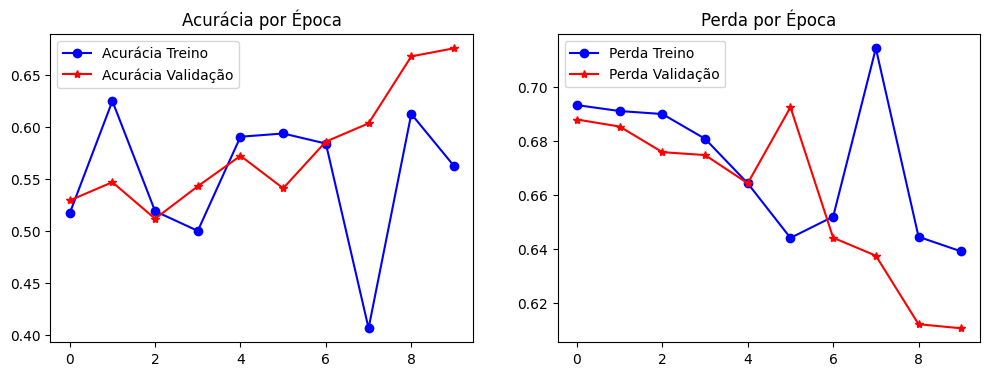

In [ ]:
# Plotagem de acurácia e perda
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Acurácia Treino')
plt.plot(epochs_range, val_acc, 'r*-', label='Acurácia Validação')
plt.title('Acurácia por Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Perda Treino')
plt.plot(epochs_range, val_loss, 'r*-', label='Perda Validação')
plt.title('Perda por Época')
plt.legend()
plt.show()


**Avaliação no conjunto de teste**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predição
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

# Avaliação
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred_classes, target_names=['Gato', 'Cachorro']))

print("Matriz de Confusão:")
print(confusion_matrix(y_true, y_pred_classes))


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 509ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

        Gato       0.67      0.65      0.66       256
    Cachorro       0.66      0.68      0.67       256

    accuracy                           0.67       512
   macro avg       0.67      0.67      0.67       512
weighted avg       0.67      0.67      0.67       512

Matriz de Confusão:
[[166  90]
 [ 81 175]]


Saving luna.png to luna (4).png


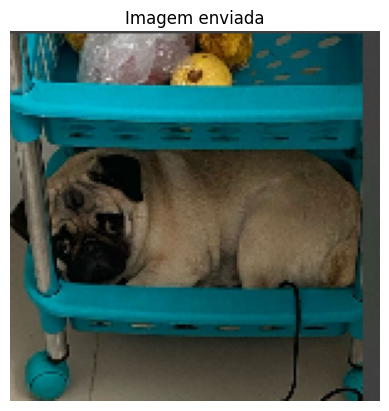

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Classe prevista: Cachorro
Confiança: 62.23%


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

# Upload da imagem (verifica se é imagem válida)
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Carrega a imagem e mostra em tela
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
plt.title('Imagem enviada')
plt.show()

# Pré-processamento: redimensiona e normaliza
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # (1, 150, 150, 3)

# Realiza predição
prediction = model.predict(img_array)[0][0]

# Interpretação da saída
classe = 'Cachorro' if prediction >= 0.5 else 'Gato'
confianca = prediction if prediction >= 0.5 else 1 - prediction

# Exibe resultado
print(f'Classe prevista: {classe}')
print(f'Confiança: {confianca * 100:.2f}%')